<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

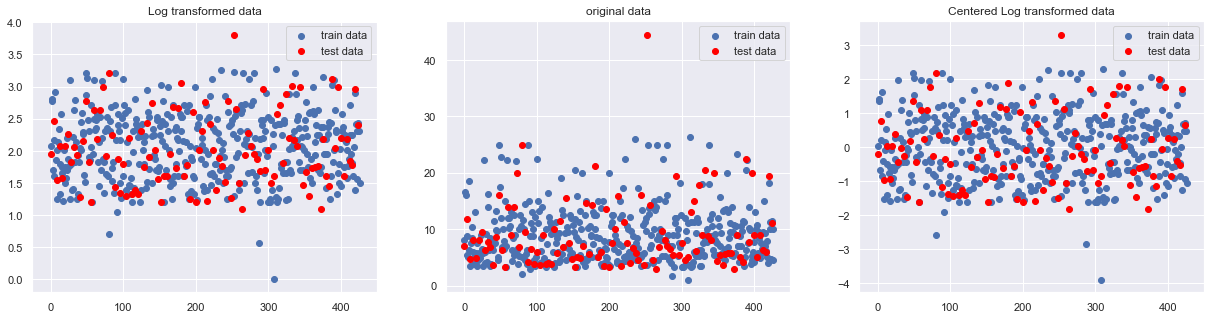

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

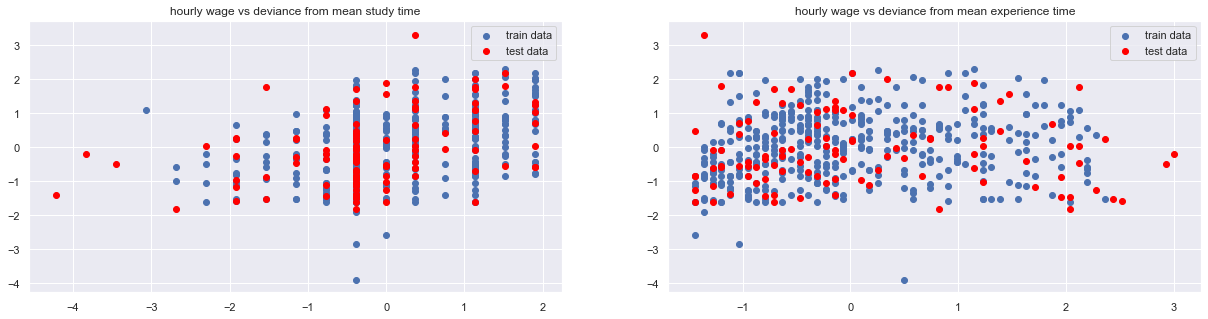

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

# Obtaining estimates

## using MAP

#### using vanilla gradient descent

In [9]:
GD.vanilla_gd(model_gaussian, max_iter= 8000)
GD.vanilla_gd(model_student, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:14
Progress : [====================] 100% Done...
   duration: 0:00:18


#### using line search

In [10]:
GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 797  duration: 0:00:02


In [11]:
GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000)

Progress : [====================] 100% Done...
   duration: 0:00:26


#### using Wolfe condition to adpat the step size

In [12]:
GD.Wolfe_cond_gd(model_gaussian, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [====================] 100% Done...
   duration: 0:00:28


In [13]:
GD.Wolfe_cond_gd(model_student, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size))

Progress : [====================] 100% Done...
   duration: 0:00:39


## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 15.8%  (advised values between 10% and 50%)
  duration: 0:00:12
iterations


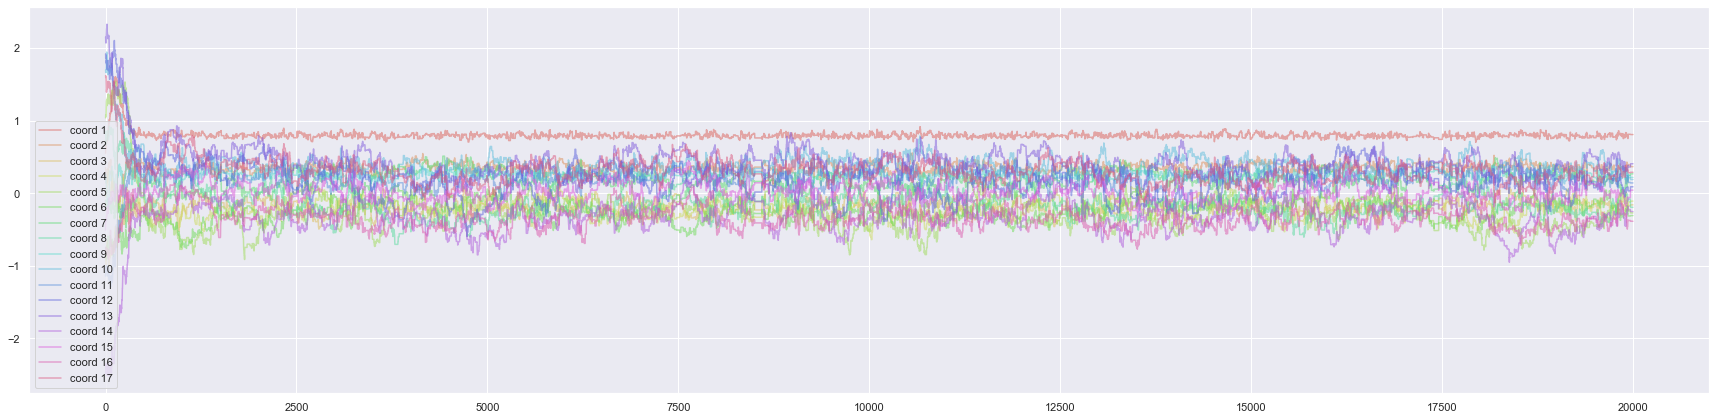

In [11]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 38.2%  (advised values between 10% and 50%)
  duration: 0:00:14
iterations


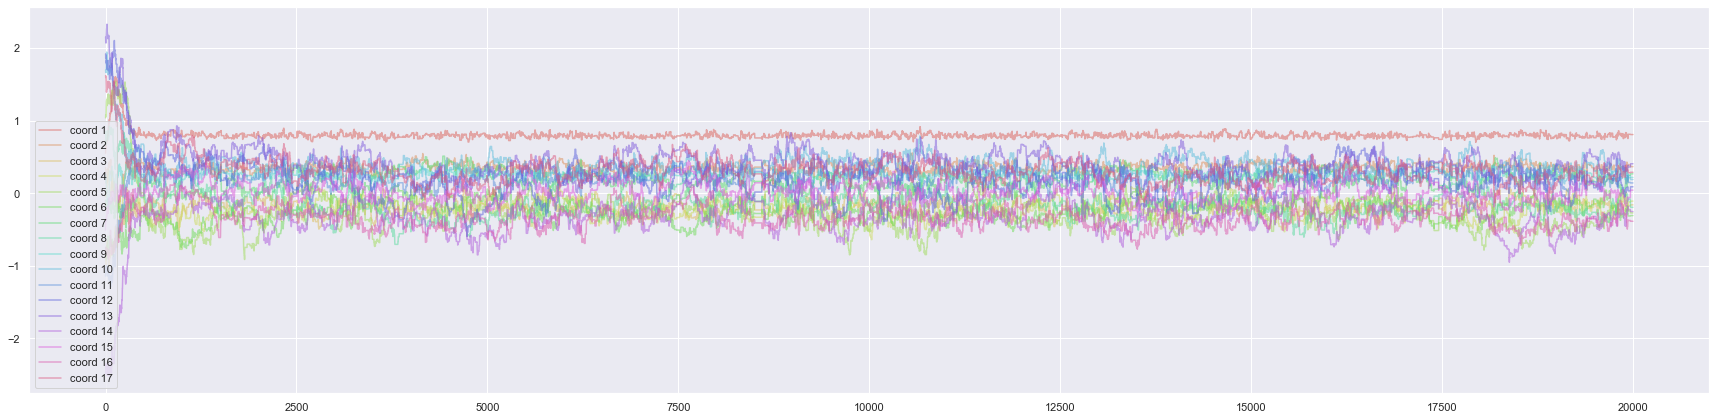

In [12]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 59.2%                 (advised values between 10% and 50%)
  duration: 0:01:27
iterations


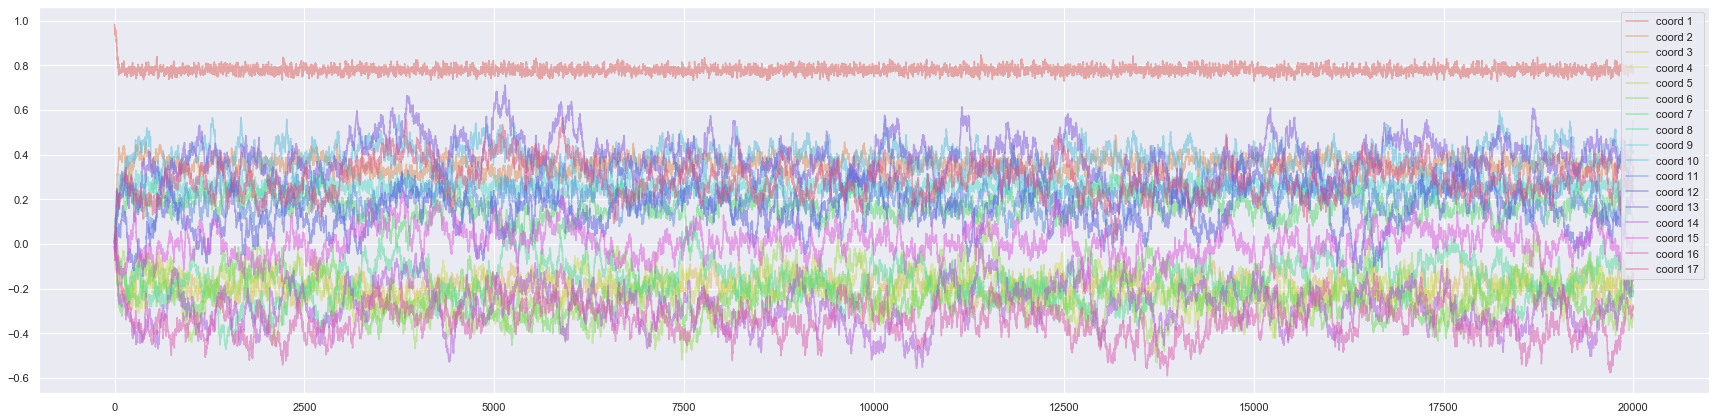

In [57]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.2%                 (advised values between 10% and 50%)
  duration: 0:02:03
iterations


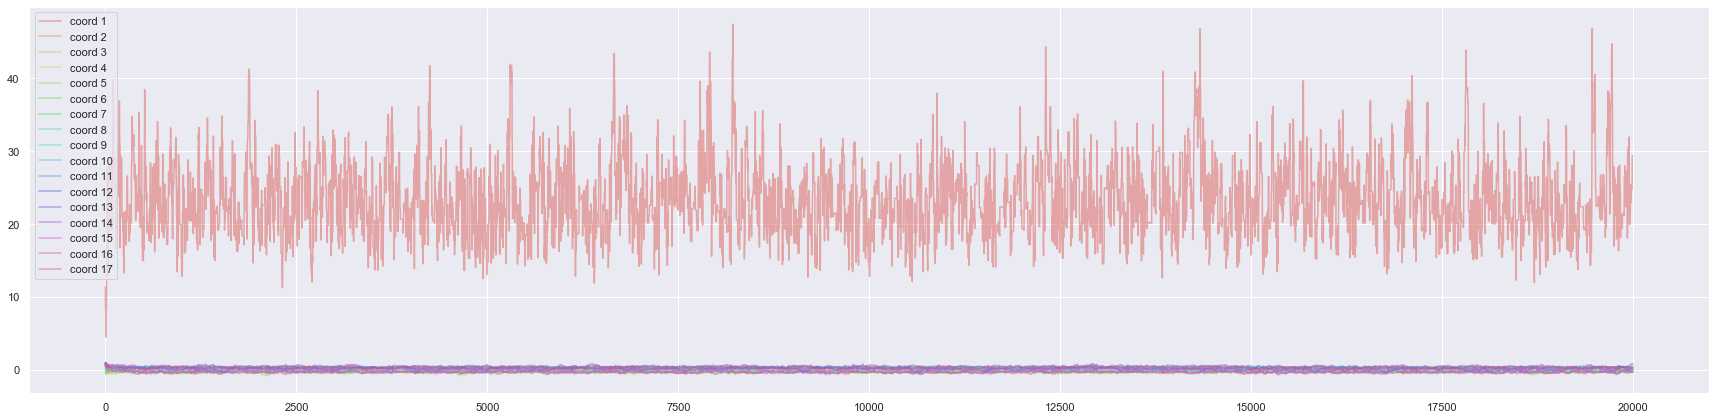

In [58]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### comparison of the metropolis hastings chains

gaussian model

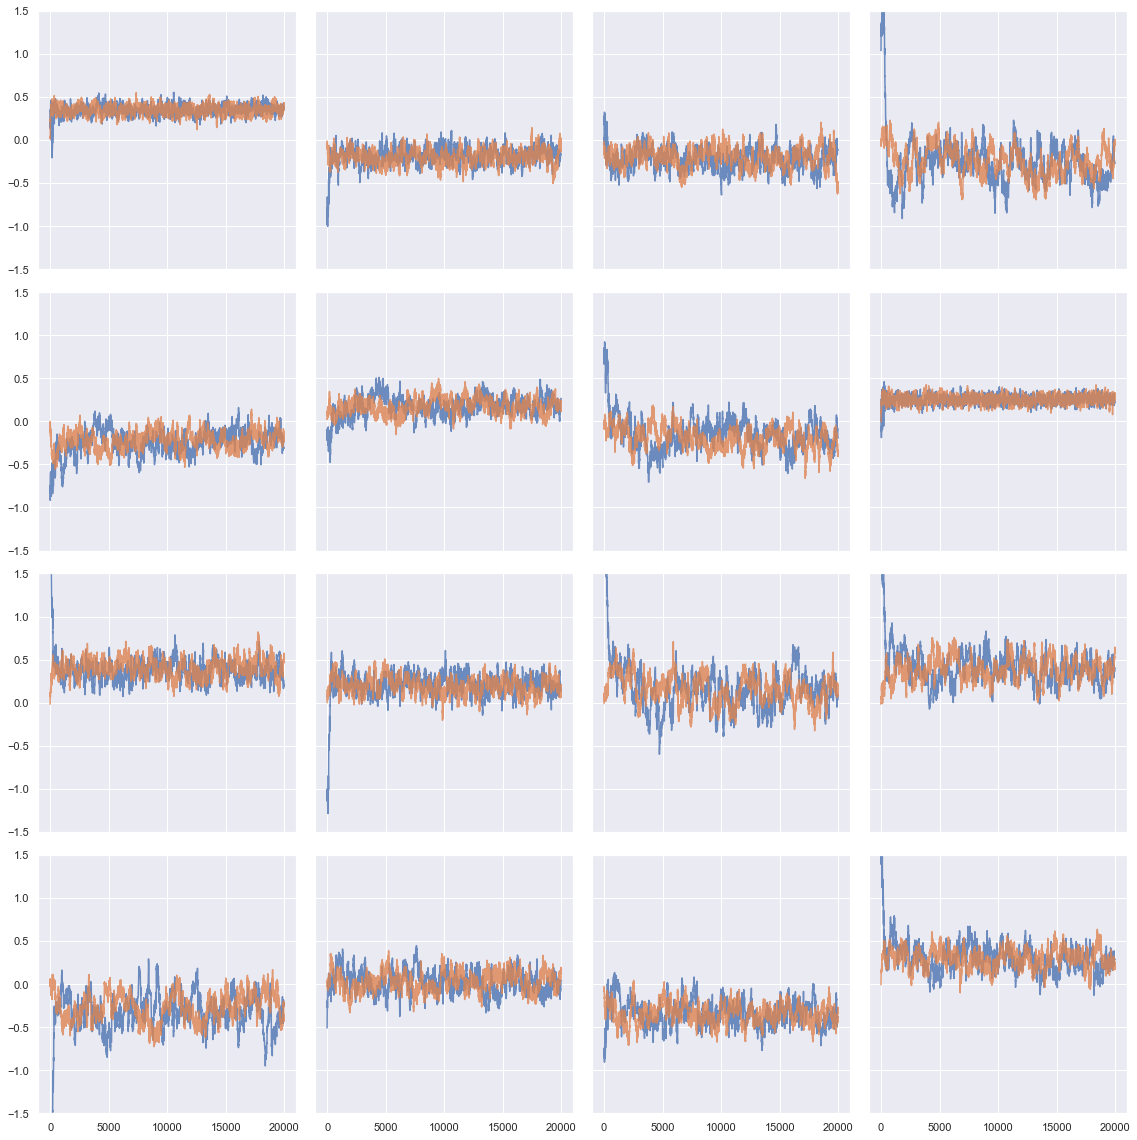

In [13]:
compare_samples_MH(samples_gaussian_rw,samples_gaussian_langevin)

student model

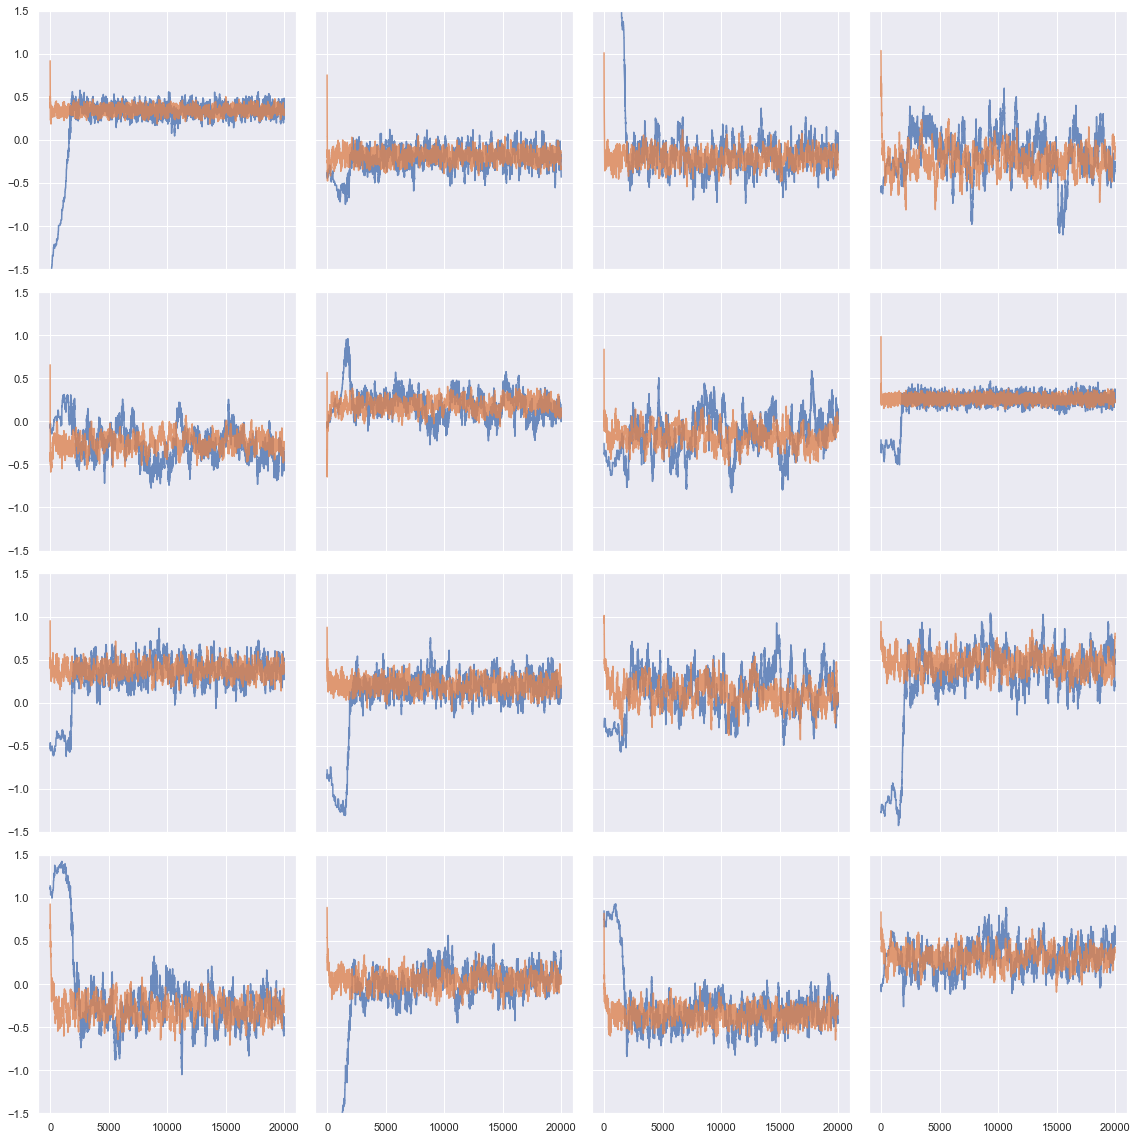

In [59]:
compare_samples_MH(samples_student_rw,samples_student_langevin)

### extraction of the estimates from the models

In [15]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
MH_Langevin_mean    0.790519  0.347551 -0.198938 -0.193104 -0.254245   
MH_Langevin_median  0.789543  0.348442 -0.201385 -0.184927 -0.260150   
MH_vanilla_mean     0.790825  0.351232 -0.179107 -0.223393 -0.271167   
MH_vanilla_median   0.788994  0.352800 -0.179717 -0.220401 -0.268832   

                          FE      MARR    MARRFE        EX     UNION  \
MH_Langevin_mean   -0.213931  0.181262 -0.204728  0.253160  0.407734   
MH_Langevin_median -0.213684  0.181870 -0.206546  0.252983  0.408075   
MH_vanilla_mean    -0.225946  0.192197 -0.179856  0.253968  0.369039   
MH_vanilla_median  -0.222625  0.188966 -0.174988  0.254109  0.366465   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
MH_Langevin_mean    0.192358  0.136728  0.396125 -0.263010  0.030873   
MH_Langevin_median  0.192975  0.139436  0.389257 -0.259017  0.028083   
MH_vanilla_mean     0.209313  0.117788  0.381706 -0.324471  0.015214   
MH_vanilla_median   0.207998  0.135021  0.381664 -0.330228  0.010065   

                        SERV      PROF  
MH_Langevin_mean   -0.346129  0.293801  
MH_Langevin_median -0.351142  0.296114  
MH_vanilla_mean    -0.349107  0.282721  
MH_vanilla_median  -0.351766  0.280211

In [22]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
MH_Langevin_mean    25.103404  0.330564 -0.223417 -0.235144 -0.209666   
MH_Langevin_median  24.348064  0.330015 -0.221174 -0.235332 -0.192399   
MH_vanilla_mean     25.150064  0.347420 -0.195290 -0.190741 -0.142632   
MH_vanilla_median   24.055888  0.348202 -0.191494 -0.187271 -0.138039   

                          FE      MARR    MARRFE        EX     UNION  \
MH_Langevin_mean   -0.308048  0.139197 -0.097383  0.255402  0.391908   
MH_Langevin_median -0.308881  0.148517 -0.096164  0.256097  0.396335   
MH_vanilla_mean    -0.288385  0.177161 -0.124383  0.262507  0.379616   
MH_vanilla_median  -0.295638  0.183875 -0.112839  0.263073  0.380004   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
MH_Langevin_mean    0.222895  0.226736  0.512790 -0.224748  0.071112   
MH_Langevin_median  0.219937  0.223571  0.520863 -0.226395  0.071174   
MH_vanilla_mean     0.196217  0.168846  0.417119 -0.277604  0.034461   
MH_vanilla_median   0.189798  0.183863  0.419116 -0.276280  0.041339   

                        SERV      PROF  
MH_Langevin_mean   -0.331870  0.359624  
MH_Langevin_median -0.331766  0.351958  
MH_vanilla_mean    -0.350020  0.313856  
MH_vanilla_median  -0.352664  0.315312

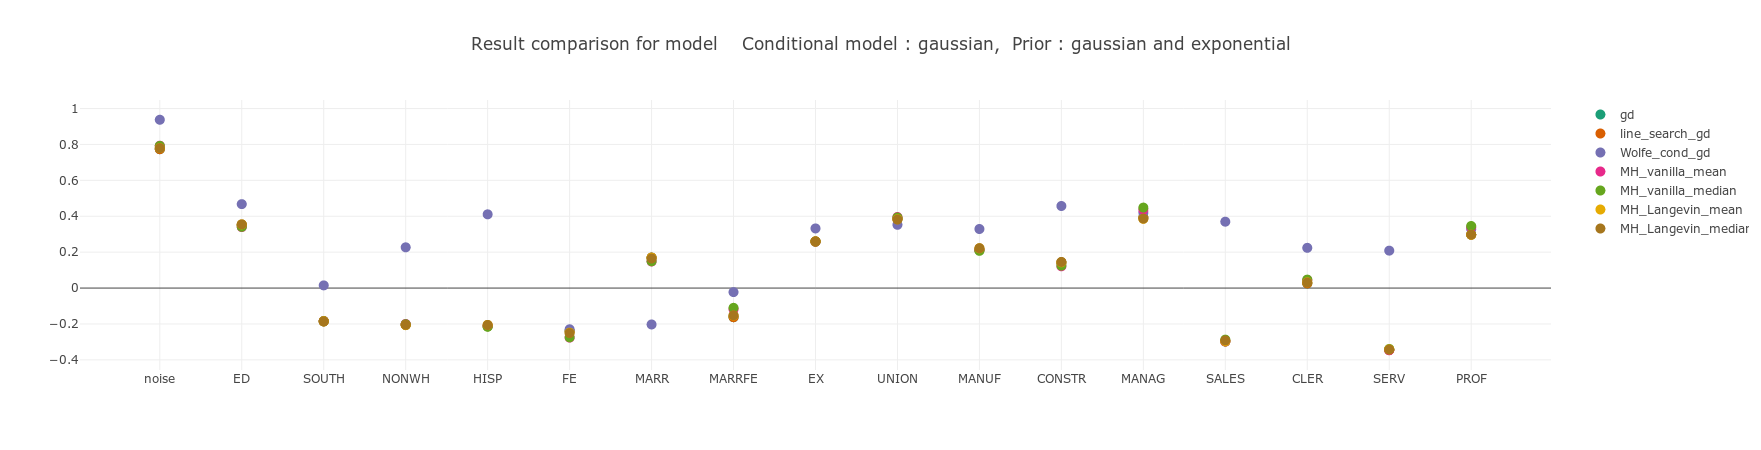

In [95]:
visualisation(r_gaussian,model_gaussian)

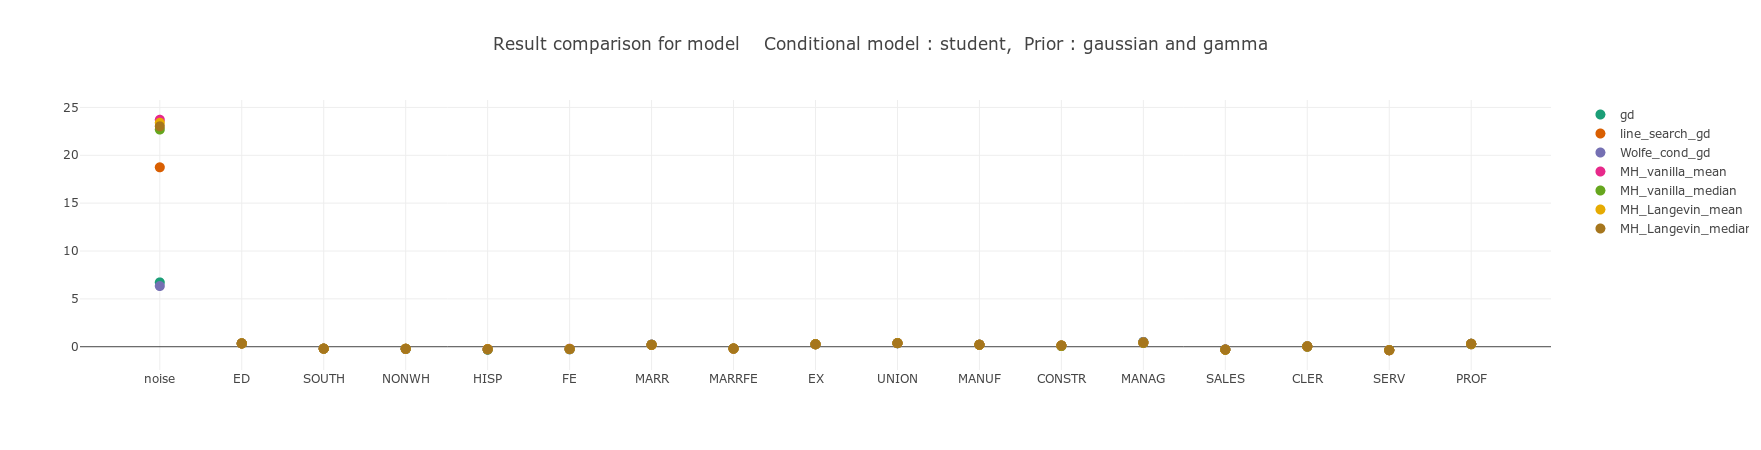

In [96]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In [24]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
gd                       0.685280        0.609907
line_search_gd           0.685159        0.611209
Wolfe_cond_gd            0.685284        0.609814
MH_vanilla_mean          0.688459        0.612368
MH_vanilla_median        0.686846        0.612502
MH_Langevin_mean         0.685689        0.611302
MH_Langevin_median       0.686182        0.611344

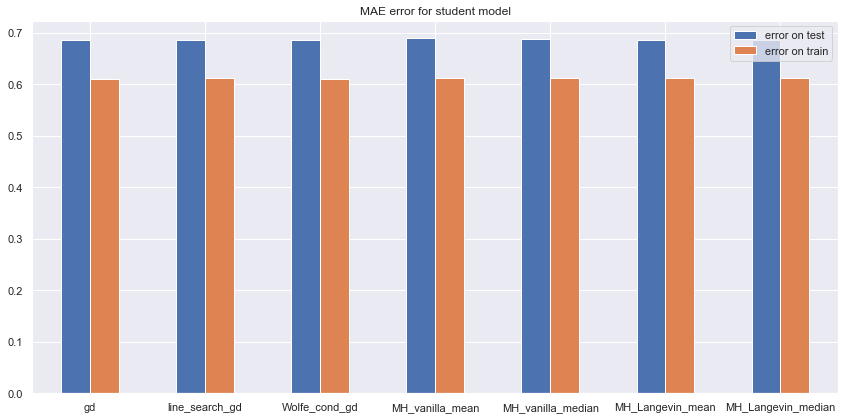

In [93]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for student model")
plt.tight_layout()
reset_plot()

In [25]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
gd                       0.685706        0.613765
line_search_gd           0.685706        0.613765
Wolfe_cond_gd            0.738525        0.692682
MH_vanilla_mean          0.683989        0.613418
MH_vanilla_median        0.684836        0.613285
MH_Langevin_mean         0.685651        0.613906
MH_Langevin_median       0.685540        0.613878

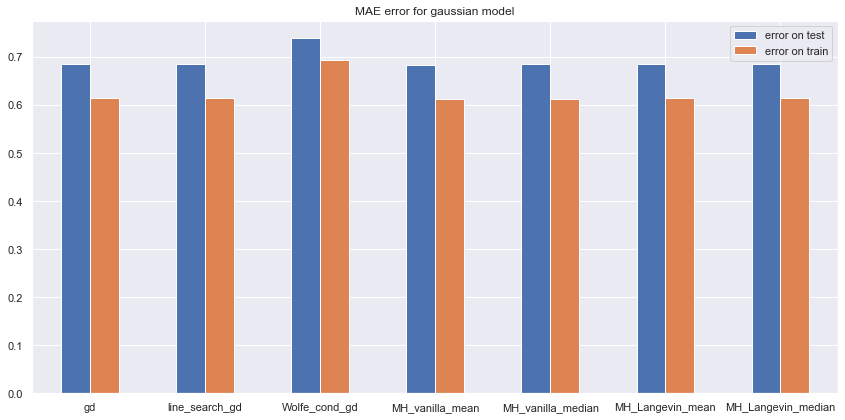

In [94]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for gaussian model")
plt.tight_layout()
reset_plot()

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

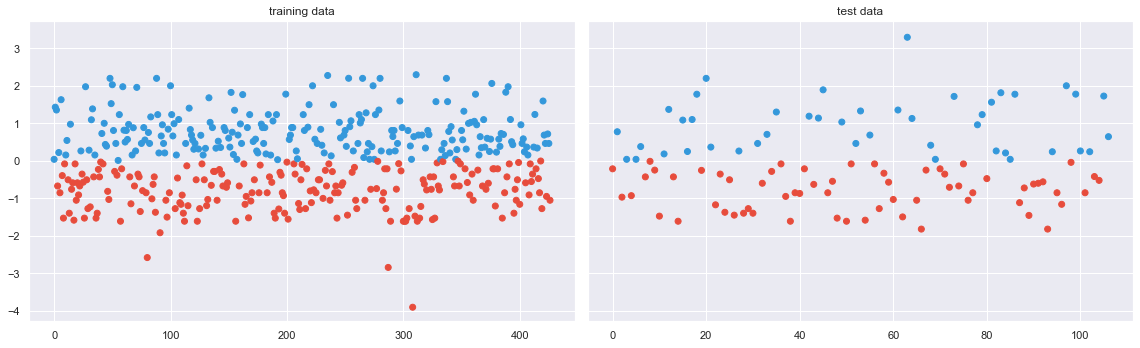

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

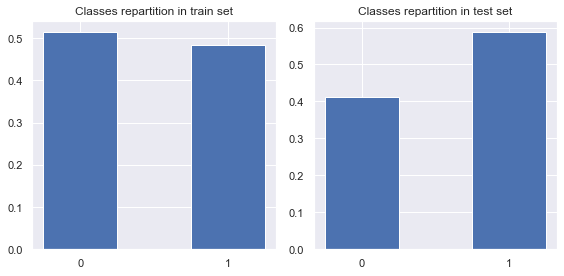

In [87]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

In [27]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,3*np.ones(16)],cond_model = [2])

In [28]:
GD.vanilla_gd(multilogi, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:07


In [29]:
GD.line_search_gd(multilogi, lambda_ = 1e-3,x0 = np.ones(multilogi.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 5606  duration: 0:00:06


In [30]:
GD.Wolfe_cond_gd(multilogi, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(multilogi.size))

Progress : [====================] 100% Done...
   duration: 0:00:11


Progress : [====================] 100% Done...
  Acceptance rate : 38.0%  (advised values between 10% and 50%)
  duration: 0:00:21
iterations


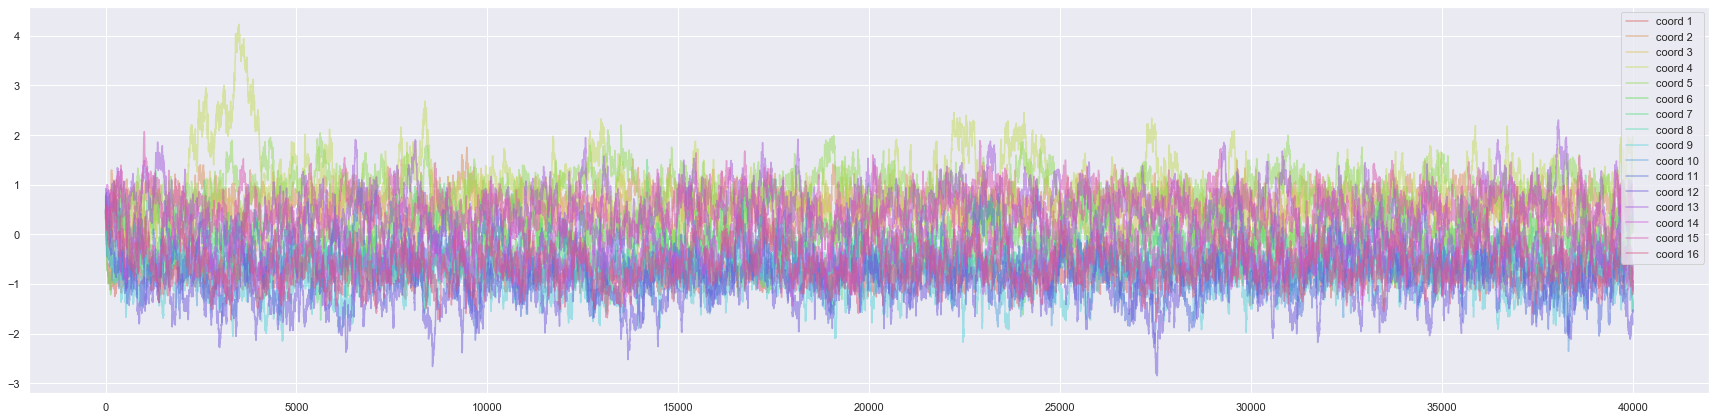

In [31]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 18.5%                 (advised values between 10% and 50%)
  duration: 0:01:19
iterations


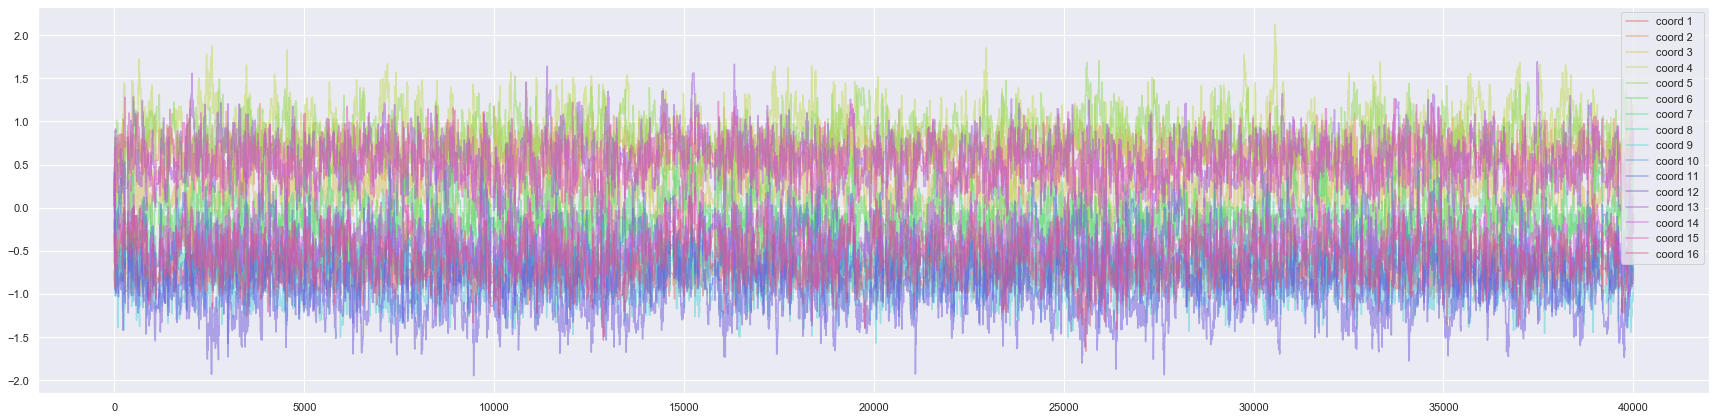

In [32]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

In [33]:
r_multilogi = multilogi()
r_multilogi.T

ED     SOUTH     NONWH      HISP        FE  \
gd                 -0.763386  0.655764  0.151902  0.429200  0.613387   
line_search_gd     -0.745740  0.637126  0.198143  0.750089  0.749299   
Wolfe_cond_gd      -0.745817  0.637126  0.198003  0.749741  0.748650   
MH_vanilla_mean    -0.778303  0.665797  0.233251  0.794251  0.841788   
MH_vanilla_median  -0.773465  0.662134  0.238195  0.766386  0.854609   
MH_Langevin_mean   -0.760624  0.647183  0.196858  0.769496  0.779063   
MH_Langevin_median -0.761896  0.646383  0.201870  0.763033  0.773186   

                        MARR    MARRFE        EX     UNION     MANUF  \
gd                 -0.363706  0.062635 -0.572882 -0.840160 -0.603316   
line_search_gd     -0.276186 -0.094773 -0.566730 -0.871967 -0.642510   
Wolfe_cond_gd      -0.276601 -0.094112 -0.566733 -0.871869 -0.642297   
MH_vanilla_mean    -0.247883 -0.175962 -0.588314 -0.943668 -0.701979   
MH_vanilla_median  -0.245272 -0.193996 -0.587814 -0.935018 -0.700625   
MH_Langevin_mean   -0.267134 -0.117531 -0.578641 -0.895592 -0.653859   
MH_Langevin_median -0.262099 -0.103241 -0.579263 -0.894918 -0.656348   

                      CONSTR     MANAG     SALES      CLER      SERV      PROF  
gd                 -0.453218 -0.839405  0.588926 -0.252744  0.608334 -0.445725  
line_search_gd     -0.481143 -0.962650  0.510775 -0.344109  0.521019 -0.564106  
Wolfe_cond_gd      -0.480883 -0.962098  0.511308 -0.343662  0.521453 -0.563554  
MH_vanilla_mean    -0.484459 -1.016015  0.499053 -0.394899  0.508166 -0.609782  
MH_vanilla_median  -0.486328 -1.002849  0.491429 -0.402433  0.510754 -0.632403  
MH_Langevin_mean   -0.497302 -0.991364  0.531258 -0.366312  0.527420 -0.592004  
MH_Langevin_median -0.496119 -0.991548  0.529249 -0.367401  0.519319 -0.590875

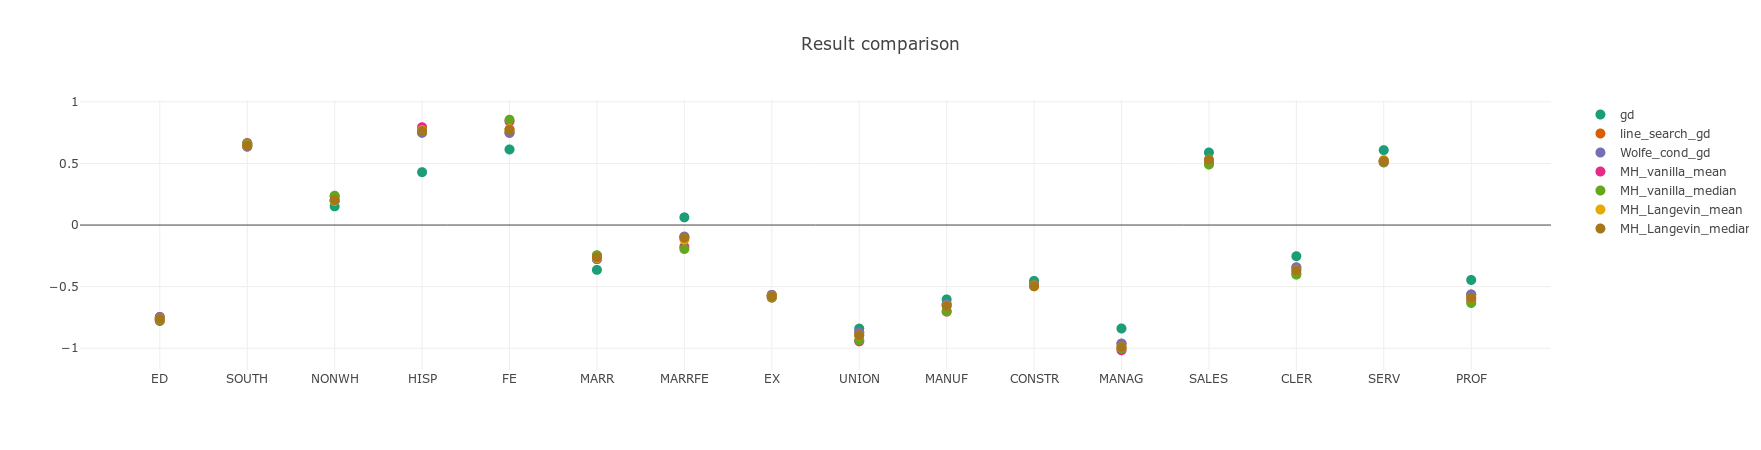

In [97]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In [52]:
predictions = multilogi.predict(X_test)
fitted = multilogi.predict(X)

In [53]:
errors = {}

In [54]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [55]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [56]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
gd                       0.448598        0.278689
line_search_gd           0.467290        0.269321
Wolfe_cond_gd            0.467290        0.269321
MH_vanilla_mean          0.467290        0.269321
MH_vanilla_median        0.467290        0.266979
MH_Langevin_mean         0.467290        0.269321
MH_Langevin_median       0.467290        0.269321

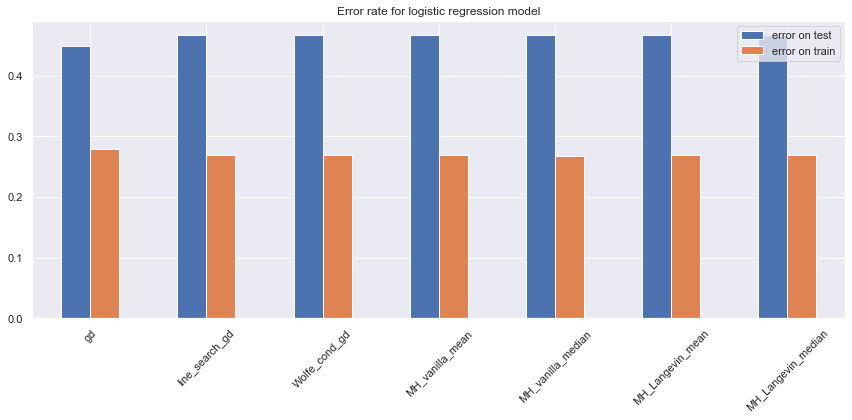

In [89]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic regression model")
plt.tight_layout()
reset_plot()